In [228]:
import triton
import triton.language as tl

# not on blackwell / hopper, using raw ptrs (not descriptors), no FP8
# my triton is old - descriptors are still experimental!

# took a lot of time to debug the fwd kernel, slept at 3AM yesterday
# hope backprop is faster

configs = [
    triton.Config({'BLOCK_MAJOR': 64, 'BLOCK_MINOR': 16}, num_stages=2, num_warps=4),
    triton.Config({'BLOCK_MAJOR': 64, 'BLOCK_MINOR': 32}, num_stages=2, num_warps=4),
    triton.Config({'BLOCK_MAJOR': 128, 'BLOCK_MINOR': 128}, num_stages=2, num_warps=4),
    triton.Config({'BLOCK_MAJOR': 128, 'BLOCK_MINOR': 32}, num_stages=2, num_warps=8),
    triton.Config({'BLOCK_MAJOR': 128, 'BLOCK_MINOR': 64}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_MAJOR': 256, 'BLOCK_MINOR': 64}, num_stages=3, num_warps=8),
]

@triton.jit
def _attn_fwd_kv_loop(
    # putting variables in scope...
    on_band: tl.constexpr,
    low, high, head_start, scale,
    q, ptr_k, ptr_v,
    offs_n: tl.constexpr, offs_row_q, offs_col: tl.constexpr,
    max_r, expsum_r, output,
    HEAD_DIM: tl.constexpr, BLOCK_N: tl.constexpr
):
    # for each row-tile of Q, loop through the K,V of tokens in range(low, high)
    for off_n in tl.range(low, high, BLOCK_N):
        # offsets of kv within a head
        offs_row_kv = off_n + offs_n
        k = tl.load(ptr_k + (head_start + offs_row_kv)[:, None] * HEAD_DIM + offs_col)
        v = tl.load(ptr_v + (head_start + offs_row_kv)[:, None] * HEAD_DIM + offs_col)
        k = k.T
        # dot product of Q [pid_m] x K [low - high]
        qk = tl.dot(q, k) * scale
        if on_band:
            causal_mask = (offs_row_q[:, None]) >= (offs_row_kv[None, :])
            qk = qk + tl.where(causal_mask, 0, -1.0e9)
        max_r_now = tl.maximum(max_r, tl.max(qk, 1))
        qk = qk - max_r_now[:, None]
        exp_qk = tl.math.exp2(qk)
        alpha = tl.math.exp2(max_r - max_r_now)
        # sum across columns - row-wise sum
        expsum_r_now = tl.sum(exp_qk, 1)
        
        output = output * (alpha[:, None])

        exp_qk = exp_qk.to(tl.float16)
        # for every entry, compute and add weight-avged values
        # use tensor cores: exp_qk(f16), v(f16), output(f32)
        output = tl.dot(exp_qk, v, output)

        expsum_r = expsum_r * alpha + expsum_r_now
        max_r = max_r_now
    return output, expsum_r, max_r

@triton.autotune(configs=configs, key=['N', 'HEAD_DIM'])
@triton.jit
def _attn_fwd (
    scale, # scaling factor 1/sqrt(d_k)
    ptr_b, # output tensor to store \log\sum_j\exp(A_{ij}) per row 
            # to be used in backward 
            # dimension: (Z * H * N, 1)
    Z, # batch size
    H, # number of heads
    N, # number of tokens
    ptr_q, # pointer to Q (Z * H * N, HEAD_DIM)
            # each row of Q corresponds to a query from a specific token in a specific head & batch
    ptr_k, # pointer to K
    ptr_v, # pointer to V (d_v = d_k)
    ptr_o, # pointer to O
    HEAD_DIM: tl.constexpr, # d^h_k
    BLOCK_MAJOR: tl.constexpr, # tile size in query direction
    BLOCK_MINOR: tl.constexpr, # ... in token sequence direction
):
    # to avoid thinking about masking, I assume:
    # 1. N is a multiple of BLOCK_M (checked outside, since N is not constexpr)
    # 2. BLOCK_N is a multiple of BLOCK_M
    BLOCK_M: tl.constexpr = BLOCK_MAJOR
    BLOCK_N: tl.constexpr = BLOCK_MINOR
    tl.static_assert(BLOCK_M % BLOCK_N == 0) 

    pid_m = tl.program_id(0) # row-tile block-id (which BLOCK_M of the Query for a specific batch & head)
    pid_hz = tl.program_id(1) # which batch and head we are in
    # we could use a 3D launch grid, but 2D might have slightly less overhead for triton
    # batch & head id
    pid_z = pid_hz // H
    pid_h = pid_hz % H

    # the range of the current head
    head_start = pid_z * (H * N) + pid_h * N
    # head_end = head_start + N

    # row offset: from head_start, moving down pid_m blocks
    off_m = pid_m * BLOCK_M
    offs_m = tl.arange(0, BLOCK_M)
    # offsets in q within a head
    offs_row_q = off_m + offs_m

    # initialize running statistics (sftmax) in SRAM / Registers
    max_r = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    expsum_r = tl.zeros([BLOCK_M], dtype=tl.float32)
    output = tl.zeros([BLOCK_M, HEAD_DIM], dtype=tl.float32)

    # becasue we use powers of 2 (faster) and exp(e) = 2^(x * log_2e)
    scale = scale * 1.44269504

    # recompute offs_row adhoc might reduce register pressure
    # offs_row (head_start + off_m + offs_m)
    
    offs_col = tl.arange(0, HEAD_DIM) # shape (HEAD_DIM,)
    
    q = tl.load(ptr_q + (head_start + offs_row_q)[:, None] * HEAD_DIM + offs_col[None, :])

    offs_n = tl.arange(0, BLOCK_N)

    # when off-band...
    low, high = 0, pid_m * BLOCK_M
    output, expsum_r, max_r= _attn_fwd_kv_loop(0, low, high, 
                    head_start, scale,
                    q, ptr_k, ptr_v,
                    offs_n, offs_row_q, offs_col, 
                    max_r, expsum_r, output,
                    HEAD_DIM, BLOCK_N)

    # when on-band..
    low, high = pid_m * BLOCK_M, tl.minimum((pid_m + 1) * BLOCK_M, N)
    output, expsum_r, max_r = _attn_fwd_kv_loop(1, low, high, head_start, scale,
                    q, ptr_k, ptr_v,
                    offs_n, offs_row_q, offs_col, 
                    max_r, expsum_r, output,
                    HEAD_DIM, BLOCK_N)

    output = output / expsum_r[:, None]
    # B stores log(sum exp)
    tl.store(ptr_b + (head_start + offs_row_q), max_r + tl.math.log2(expsum_r)) 
    tl.store(ptr_o + (head_start + offs_row_q)[:, None] * HEAD_DIM + offs_col[None, :], output.to(tl.float16))

In [234]:
import triton
import triton.language as tl

@triton.autotune(configs=[
    triton.Config({'BLOCK_MAJOR': 32}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_MAJOR': 64}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_MAJOR': 128}, num_stages=3, num_warps=8),
], key=['N', 'HEAD_DIM'])
@triton.jit
def _attn_bwd_prep(
    O, DO,
    Delta,
    Z, H, N,
    HEAD_DIM: tl.constexpr,
    BLOCK_MAJOR: tl.constexpr
):
    BLOCK_M: tl.constexpr = BLOCK_MAJOR
    pid_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, HEAD_DIM)
    o = tl.load(O + (off_hz * N + offs_m[:, None]) * HEAD_DIM + offs_n[None, :])
    do = tl.load(DO + (off_hz * N + offs_m[:, None]) * HEAD_DIM + offs_n[None, :]).to(tl.float32)
    delta = tl.sum(o * do, axis=1)
    tl.store(Delta + off_hz * N + offs_m, delta)

@triton.jit
def _attn_bwd_dkdv(
    on_band: tl.constexpr,
    dk, dv,
    Q, k, v, scale,
    DO, B, D,
    start_n, start_m, num_steps,
    BLOCK_M1: tl.constexpr,
    BLOCK_N1: tl.constexpr,
    HEAD_DIM: tl.constexpr
):
    offs_m = start_m + tl.arange(0, BLOCK_M1)
    offs_n = start_n + tl.arange(0, BLOCK_N1)
    offs_col = tl.arange(0, HEAD_DIM)

    # load in qT at row-tile m / HEAD_DIM
    ptr_qT = Q + offs_m[None, :] * HEAD_DIM + offs_col[:, None]
    ptr_do = DO + offs_m[:, None] * HEAD_DIM + offs_col[None, :]
    curr_m = start_m
    # for dV, we need corresponding DO and DT
    # hold n on dK, dV, slide m on Q, DO
    for idx in range(num_steps):
        qT = tl.load(ptr_qT) 
        # slide down offs_m
        offs_m = curr_m + tl.arange(0, BLOCK_M1)
        b = tl.load(B + offs_m)
        # first, calculate DT. use the exp2 trick again
        kTq = tl.dot(k, qT) * scale * 1.4426950408889634
        dT = tl.math.exp2(kTq - b[None, :])
        if on_band:
            # need m >= n (just DT)
            mask = (offs_m[None, :] >= offs_n[:, None])
            dT = tl.where(mask, dT, 0.0)
        do = tl.load(ptr_do)
        dT_f16 = dT.to(tl.float16)
        dv += tl.dot(dT_f16, do)
        delta = tl.load(D + offs_m)
        # dD, no accumulation needed since we have full head_dim
        ddT = tl.dot(v, tl.trans(do)).to(tl.float32)
        daT = dT * (ddT - delta[None, :])
        daT = daT.to(tl.float16)
        dk += tl.dot(daT, tl.trans(qT))

        curr_m += BLOCK_M1
        ptr_qT += BLOCK_M1 * HEAD_DIM
        ptr_do += BLOCK_M1 * HEAD_DIM
    
    # THIS IS WRONG BECAUSE THE FUNCTION IS CALLED TWICE!!!
    # dk = dk * scale

    return dk, dv 
        
@triton.jit
def _attn_bwd_dq(
    on_band: tl.constexpr,
    dq, q, K, V, scale,
    do, b, D,
    start_m, start_n, num_steps,
    BLOCK_M2: tl.constexpr, 
    BLOCK_N2: tl.constexpr,
    HEAD_DIM: tl.constexpr
): 
    offs_m = start_m + tl.arange(0, BLOCK_M2)
    offs_n = start_n + tl.arange(0, BLOCK_N2)
    offs_col = tl.arange(0, HEAD_DIM)
    ptr_vT = V + offs_n[None, :] * HEAD_DIM + offs_col[:, None]
    ptr_kT = K + offs_n[None, :] * HEAD_DIM + offs_col[:, None]
    delta = tl.load(D + offs_m)
    curr_n = start_n
    for idx in range(num_steps):
        kT = tl.load(ptr_kT)
        vT = tl.load(ptr_vT)
        qk = tl.dot(q, kT)
        qk = qk * scale * 1.4426950408889634
        d = tl.math.exp2(qk - b)
        if on_band:
            offs_n = curr_n + tl.arange(0, BLOCK_N2)
            mask = (offs_m[:, None]) >= (offs_n[None, :])
            d = tl.where(mask, d, 0.0)
        dd = tl.dot(do, vT).to(tl.float32)
        da = d * (dd - delta[:, None])
        da = da.to(tl.float16)
        dq += tl.dot(da, tl.trans(kT)) * scale
        curr_n += BLOCK_N2
        ptr_kT += BLOCK_N2 * HEAD_DIM
        ptr_vT += BLOCK_N2 * HEAD_DIM
    
    return dq

@triton.autotune(configs=configs, key=['N', 'HEAD_DIM'])
@triton.jit
def _attn_bwd(
    Q, K, V, scale,
    DO, DQ, DK, DV,
    B, D,
    Z, H, N,
    HEAD_DIM: tl.constexpr,
    BLOCK_MAJOR: tl.constexpr,
    BLOCK_MINOR: tl.constexpr
):
    BLOCK_M1: tl.constexpr = BLOCK_MINOR
    BLOCK_N1: tl.constexpr = BLOCK_MAJOR
    BLOCK_M2: tl.constexpr = BLOCK_MAJOR
    BLOCK_N2: tl.constexpr = BLOCK_MINOR
    # assumptions, so that I don't need to think about masks
    # for dK, dV, we fix n and scan m
    # for dQ, we fix m and scan n 
    tl.static_assert(BLOCK_MAJOR % BLOCK_MINOR == 0)
    
    pid = tl.program_id(0)
    pid_hz = tl.program_id(1)
    head_start = pid_hz * N
    off_head_start_off = head_start * HEAD_DIM

    # move pointers to head
    Q += off_head_start_off
    K += off_head_start_off
    V += off_head_start_off
    DO += off_head_start_off
    DQ += off_head_start_off
    DK += off_head_start_off
    DV += off_head_start_off
    B += head_start
    D += head_start

    offs_col = tl.arange(0, HEAD_DIM)

    # for dk, dv, move to the corresponding row_tile
    start_n = pid * BLOCK_N1
    # for O, moving to corresponding starting position
    # causal masking: on-band: start_n -> + BLOCK_N1
    #                off-band: + BLOCK_N1 -> N
    start_m = start_n

    # offsets for loading n
    offs_n = start_n + tl.arange(0, BLOCK_N1)

    # output tiles
    dv = tl.zeros([BLOCK_N1, HEAD_DIM], dtype=tl.float32)
    dk = tl.zeros([BLOCK_N1, HEAD_DIM], dtype=tl.float32)

    # load corresponding tiles for K and V
    # they stay constant
    k = tl.load(K + offs_n[:, None] * HEAD_DIM + offs_col[None, :])
    v = tl.load(V + offs_n[:, None] * HEAD_DIM + offs_col[None, :])

    num_steps = BLOCK_N1 // BLOCK_M1

    dk, dv = _attn_bwd_dkdv(1, dk, dv,
                            Q, k, v, scale,
                            DO, B, D,
                            start_n, start_m, num_steps,
                            BLOCK_M1, BLOCK_N1,
                            HEAD_DIM)

    start_m += BLOCK_N1
    num_steps = (N - start_m) // BLOCK_M1

    dk, dv = _attn_bwd_dkdv(0, dk, dv,
                            Q, k, v, scale,
                            DO, B, D,
                            start_n, start_m, num_steps,
                            BLOCK_M1, BLOCK_N1,
                            HEAD_DIM)

    tl.store(DV + offs_n[:, None] * HEAD_DIM + offs_col, dv)
    tl.store(DK + offs_n[:, None] * HEAD_DIM + offs_col, dk * scale)

    # on-band dq
    # for dq, in this row-tile. uses the same dO
    start_m = pid * BLOCK_M2
    # for K, V, we start from start_m and end at one BLOCK_M2 over: 
    end_n = start_m + BLOCK_M2
    offs_m = start_m + tl.arange(0, BLOCK_M2)

    # prepare values for dq, those values are fixed
    q = tl.load(Q + offs_m[:, None] * HEAD_DIM + offs_col)
    dq = tl.zeros([BLOCK_M2, HEAD_DIM], dtype=tl.float32)
    do = tl.load(DO + offs_m[:, None] * HEAD_DIM + offs_col)
    b = tl.load(B + offs_m)[:, None]
    num_steps = BLOCK_M2 // BLOCK_N2

    dq = _attn_bwd_dq(1,
                      dq, q, K, V, scale,
                      do, b, D, 
                      start_m, start_n, num_steps,
                      BLOCK_M2, BLOCK_N2, HEAD_DIM)

    # for the 2nd stage, we go from end_n to 0 for K, V
    end_n -= BLOCK_M2

    num_steps = end_n // BLOCK_N2

    dq = _attn_bwd_dq(0,
                      dq, q, K, V, scale,
                      do, b, D, 
                      start_m, 0, num_steps,
                      BLOCK_M2, BLOCK_N2, HEAD_DIM)

    tl.store(DQ + offs_m[:, None] * HEAD_DIM + offs_col[None, :], dq)

In [ ]:
import torch
import triton
import triton.language as tl
import math

def test_attn_bwd():
    torch.manual_seed(0)

    DEVICE = torch.device("cuda:0")

    Z, H, N, HEAD_DIM = 2, 3, 512, 128
    scale = 1.0 / math.sqrt(HEAD_DIM)

    # Inputs
    Q = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()
    K = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()
    V = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()
    DO = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()

    # Reference output using PyTorch
    Q_ref = Q.clone().detach().requires_grad_()
    K_ref = K.clone().detach().requires_grad_()
    V_ref = V.clone().detach().requires_grad_()

    O_ref = torch.nn.functional.scaled_dot_product_attention(
        Q_ref, K_ref, V_ref, attn_mask=None, dropout_p=0.0, is_causal=True
    ).to(torch.float16)
    O_ref.backward(DO)
    O_ref = O_ref.reshape(Z * H * N, HEAD_DIM)

    # Triton backward tensors (flattened)
    Q_flat = Q.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    K_flat = K.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    V_flat = V.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    DO_flat = DO.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    O = torch.zeros_like(Q_flat)
    Delta = torch.zeros((Z * H * N), dtype=torch.float16, device=DEVICE).contiguous()
    B = torch.ones((Z * H * N), dtype=torch.float32, device=DEVICE).contiguous()
    DQ_flat = torch.empty_like(Q_flat)
    DK_flat = torch.empty_like(K_flat)
    DV_flat = torch.empty_like(V_flat)

    grid = lambda meta: (triton.cdiv(N, meta['BLOCK_MAJOR']), Z * H)

    _attn_fwd[grid](
        scale, B, Z, H, N,
        Q_flat, K_flat, V_flat, O,
        HEAD_DIM#, BLOCK_MAJOR, BLOCK_MINOR
    )
    
    #A = torch.matmul(Q_flat, K_flat.T) * scale  
    #torch.testing.assert_close(O, O_ref, atol=1e-2, rtol=1e-2)
    #mask = torch.triu(torch.ones_like(A), diagonal=1).bool()
    #A_masked = A.masked_fill(mask, float('-inf'))
    #max_A, _ = A_masked.max(dim=1, keepdim=True)
    #log2sumexp = (max_A  * 1.4426950408889634 + (A_masked - max_A).exp().sum(dim=1, keepdim=True).log2()).squeeze(1).to(torch.float32)
    #torch.testing.assert_close(B, log2sumexp, atol=1e-2, rtol=1e-2)

    _attn_bwd_prep[grid](
        O, DO_flat,
        Delta,
        Z, H, N,
        HEAD_DIM=HEAD_DIM
    )

    #Delta_ref = (O * DO_flat).sum(dim=1)
    #torch.testing.assert_close(Delta, Delta_ref, atol=1e-2, rtol=1e-2)

    # Step 2: Launch _attn_bwd
    _attn_bwd[grid](
        Q_flat, K_flat, V_flat, scale,
        DO_flat, DQ_flat, DK_flat, DV_flat,
        B, Delta,
        Z, H, N,
        HEAD_DIM=HEAD_DIM
    )

    #D = torch.nn.functional.softmax(A_masked, dim = -1)
    #DDT = torch.matmul(V_flat, DO_flat.T)
    #DAT = D.T * (DDT - Delta[None, :])
    #DK = torch.matmul(DAT, Q_flat)
    #print(DK_flat - DK * scale)
    #print(DQ_flat - Q_ref.grad)
    #print(Delta)
    #print(DK)
    #print(DK * scale - DK_flat)
    #print(DK * scale - K_ref.grad)


    torch.testing.assert_close(DQ_flat, Q_ref.grad.reshape(Z * H * N, HEAD_DIM), atol=1e-2, rtol=1e-2)
    torch.testing.assert_close(DK_flat, K_ref.grad.reshape(Z * H * N, HEAD_DIM), atol=1e-2, rtol=1e-2)
    torch.testing.assert_close(DV_flat, V_ref.grad.reshape(Z * H * N, HEAD_DIM), atol=1e-2, rtol=1e-2)

    #AT = torch.matmul(K_flat.T, Q_flat) * scale
    #DT = torch.nn.functional.softmax(AT, dim = -1)
    #print(DT)
    #print(DV_flat - V_ref.grad.reshape(Z * H * N, HEAD_DIM))
    
    #print(D.T, DO_flat)
    #print(torch.matmul(D.T, DO_flat) - DV_flat)
    #print(V_ref.grad.reshape(Z * H * N, HEAD_DIM))


if __name__ == "__main__":
    test_attn_bwd()

=== GPU Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB
Compute Capability: 8.6

=== Running Sequence Length Benchmark ===


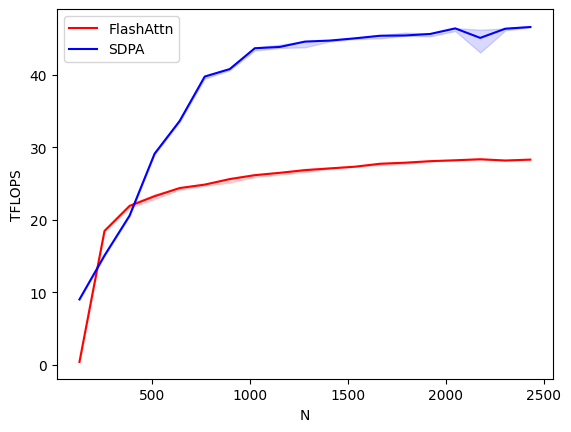

flash-attention-forward:
         N  FlashAttn       SDPA
0    128.0   0.369300   9.002198
1    256.0  18.460845  15.065747
2    384.0  21.910253  20.565691
3    512.0  23.250023  29.127112
4    640.0  24.380953  33.642712
5    768.0  24.855627  39.772353
6    896.0  25.616336  40.814233
7   1024.0  26.158813  43.690665
8   1152.0  26.486458  43.871207
9   1280.0  26.850213  44.606588
10  1408.0  27.093945  44.750881
11  1536.0  27.331975  45.059131
12  1664.0  27.737501  45.414072
13  1792.0  27.882816  45.453137
14  1920.0  28.093279  45.660495
15  2048.0  28.219768  46.433122
16  2176.0  28.356547  45.118643
17  2304.0  28.186778  46.388046
18  2432.0  28.307763  46.619562


In [241]:
import torch

DEVICE = torch.device("cuda:0")

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(1, 20)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['FlashAttn', 'SDPA'],
        styles=[('red', '-'), ('blue', '-')],
        ylabel='TFLOPS',
        plot_name='flash-attention-forward',
        args={'Z': 100, 'H': 8, 'HEAD_DIM': 128, 'dtype': torch.float16},
    ))
def bench_flash_attention(Z, H, N, HEAD_DIM, dtype, provider, device=DEVICE):
    torch.manual_seed(42)
    scale = 1.0 / (HEAD_DIM ** 0.5)
    
    Q = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    K = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    V = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    
    quantiles = [0.5, 0.2, 0.8]

    def triton_fwd():
        Q_flat = Q.reshape(Z * H * N, HEAD_DIM).contiguous()
        K_flat = K.reshape(Z * H * N, HEAD_DIM).contiguous()
        V_flat = V.reshape(Z * H * N, HEAD_DIM).contiguous()
        O = torch.empty_like(Q_flat)
        B = torch.empty(Z * H * N, dtype=torch.float32, device=DEVICE)
        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_MAJOR']), Z * H)
        
        _attn_fwd[grid](
            scale, B, Z, H, N,
            Q_flat, K_flat, V_flat, O,
            HEAD_DIM=HEAD_DIM
        )
        return O.reshape(Z, H, N, HEAD_DIM)

    def torch_fwd():
        return torch.nn.functional.scaled_dot_product_attention(
            Q, K, V, attn_mask=None, dropout_p=0.0, is_causal=True
        )

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(triton_fwd, quantiles=quantiles, rep=100)
    elif provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(torch_fwd, quantiles=quantiles, rep=100)
    
    # 2 * batch * heads * seq_len^2 * head_dim (QK^T + softmax + AV)
    # for causal attention, roughly half the operations
    flops_per_attention = 2.0 * Z * H * N * N * HEAD_DIM * 0.5  # 0.5 for causal
    tflops = flops_per_attention * 1e-12 / (ms * 1e-3)
    tflops_min = flops_per_attention * 1e-12 / (max_ms * 1e-3)  
    tflops_max = flops_per_attention * 1e-12 / (min_ms * 1e-3)
    
    return tflops, tflops_min, tflops_max

if __name__ == "__main__":
    print("=== GPU Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print(f"Name: {specs.name}")
    print(f"SM Count: {specs.multi_processor_count}")
    print(f"Device Memory: {specs.total_memory // (1024 ** 2)} MB")
    print(f"Compute Capability: {specs.major}.{specs.minor}")
    
    print("\n=== Running Sequence Length Benchmark ===")
    bench_flash_attention.run(show_plots=True, print_data=True)

=== GPU Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB
Compute Capability: 8.6

=== Running Sequence Length Benchmark ===


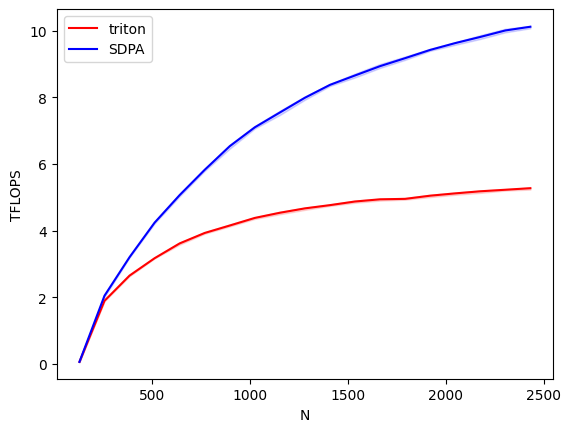

flash-attention-forward:
         N    triton       SDPA
0    128.0  0.060169   0.060862
1    256.0  1.894104   2.048000
2    384.0  2.652086   3.205565
3    512.0  3.173656   4.241812
4    640.0  3.618375   5.069307
5    768.0  3.932160   5.828300
6    896.0  4.155362   6.537589
7   1024.0  4.383679   7.104174
8   1152.0  4.538660   7.548942
9   1280.0  4.670468   7.992195
10  1408.0  4.767831   8.378968
11  1536.0  4.876594   8.661145
12  1664.0  4.942692   8.940575
13  1792.0  4.955654   9.180286
14  1920.0  5.051247   9.428133
15  2048.0  5.120625   9.633220
16  2176.0  5.183334   9.817491
17  2304.0  5.229451  10.012101
18  2432.0  5.276203  10.124314


In [240]:
import torch

DEVICE = torch.device("cuda:0")

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(1, 20)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['triton', 'SDPA'],
        styles=[('red', '-'), ('blue', '-')],
        ylabel='TFLOPS',
        plot_name='flash-attention-forward',
        args={'Z': 5, 'H': 8, 'HEAD_DIM': 128, 'dtype': torch.float16},
    ))
def bench_flash_attention(Z, H, N, HEAD_DIM, dtype, provider, device=DEVICE):
    torch.manual_seed(42)
    scale = 1.0 / (HEAD_DIM ** 0.5)
    
    Q = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    K = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    V = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    
    quantiles = [0.5, 0.2, 0.8]

    def triton_bwd():
        Q_ = Q.detach().clone().reshape(Z * H * N, HEAD_DIM).contiguous()
        K_ = K.detach().clone().reshape(Z * H * N, HEAD_DIM).contiguous()
        V_ = V.detach().clone().reshape(Z * H * N, HEAD_DIM).contiguous()
        DO_ = torch.randn_like(Q_)

        O_ = torch.empty_like(Q_)
        B_ = torch.empty(Z * H * N, dtype=torch.float32, device=device)
        Delta_ = torch.empty(Z * H * N, dtype=torch.float16, device=device)
        DQ_ = torch.empty_like(Q_)
        DK_ = torch.empty_like(K_)
        DV_ = torch.empty_like(V_)

        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_MAJOR']), Z * H)

        _attn_fwd[grid](
            scale, B_, Z, H, N,
            Q_, K_, V_, O_,
            HEAD_DIM=HEAD_DIM
        )

        _attn_bwd_prep[grid](
            O_, DO_,
            Delta_,
            Z, H, N,
            HEAD_DIM=HEAD_DIM
        )

        _attn_bwd[grid](
            Q_, K_, V_, scale,
            DO_, DQ_, DK_, DV_,
            B_, Delta_,
            Z, H, N,
            HEAD_DIM=HEAD_DIM
        )

    def torch_bwd():
        Q_ref = Q.detach().clone().requires_grad_()
        K_ref = K.detach().clone().requires_grad_()
        V_ref = V.detach().clone().requires_grad_()
        DO_ref = torch.randn_like(Q_ref)

        O_ref = torch.nn.functional.scaled_dot_product_attention(
            Q_ref, K_ref, V_ref, attn_mask=None, dropout_p=0.0, is_causal=True
        )
        O_ref.backward(DO_ref)

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(triton_bwd, quantiles=quantiles, rep=100)
    elif provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(torch_bwd, quantiles=quantiles, rep=100)
    
    # batch * heads * seq_len^2 * head_dim (EFFECTIVE FLOPS) 
    flops_per_attention = Z * H * N * N * HEAD_DIM
    tflops = flops_per_attention * 1e-12 / (ms * 1e-3)
    tflops_min = flops_per_attention * 1e-12 / (max_ms * 1e-3)  
    tflops_max = flops_per_attention * 1e-12 / (min_ms * 1e-3)
    
    return tflops, tflops_min, tflops_max

if __name__ == "__main__":
    print("=== GPU Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print(f"Name: {specs.name}")
    print(f"SM Count: {specs.multi_processor_count}")
    print(f"Device Memory: {specs.total_memory // (1024 ** 2)} MB")
    print(f"Compute Capability: {specs.major}.{specs.minor}")
    
    print("\n=== Running Sequence Length Benchmark ===")
    bench_flash_attention.run(show_plots=True, print_data=True)